# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target_folder = 'model'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      200
batch_size =    128
learning_rate = 0.0001
dropout =       0.2
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/phonon-database',
                             targets=['free-energy'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)
    
    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset, transformation='inverse-quadratic')
    
    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(5, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

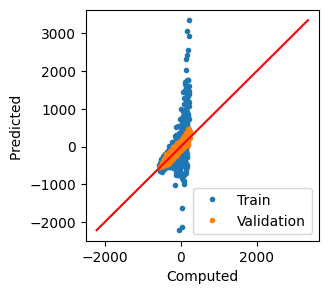

Epoch: 1, Train MAE: 84.4474, Val MAE: 38.7620
Epoch: 2, Train MAE: 46.8160, Val MAE: 32.2556
Epoch: 3, Train MAE: 40.4602, Val MAE: 30.0008
Epoch: 4, Train MAE: 35.0546, Val MAE: 27.1904
Epoch: 5, Train MAE: 33.1073, Val MAE: 26.7520
Epoch: 6, Train MAE: 31.3565, Val MAE: 25.4436
Epoch: 7, Train MAE: 30.6297, Val MAE: 24.3817
Epoch: 8, Train MAE: 29.0913, Val MAE: 23.3221
Epoch: 9, Train MAE: 28.1873, Val MAE: 23.3924
Epoch: 10, Train MAE: 27.6204, Val MAE: 22.6109


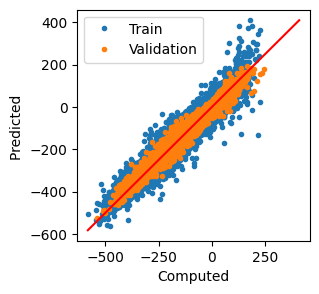

Epoch: 11, Train MAE: 26.4607, Val MAE: 21.7604
Epoch: 12, Train MAE: 25.7350, Val MAE: 21.4681
Epoch: 13, Train MAE: 24.9441, Val MAE: 21.0479
Epoch: 14, Train MAE: 24.4411, Val MAE: 21.8059
Epoch: 15, Train MAE: 24.0292, Val MAE: 20.7517
Epoch: 16, Train MAE: 23.1747, Val MAE: 20.5789
Epoch: 17, Train MAE: 22.7197, Val MAE: 19.7627
Epoch: 18, Train MAE: 22.1268, Val MAE: 19.6646
Epoch: 19, Train MAE: 21.7034, Val MAE: 20.2236
Epoch: 20, Train MAE: 21.2464, Val MAE: 20.0229


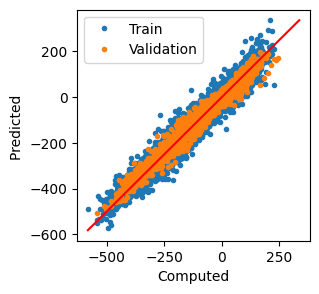

Epoch: 21, Train MAE: 20.9247, Val MAE: 19.2091
Epoch: 22, Train MAE: 20.5952, Val MAE: 19.5997
Epoch: 23, Train MAE: 20.4191, Val MAE: 18.5930
Epoch: 24, Train MAE: 19.9672, Val MAE: 18.5138
Epoch: 25, Train MAE: 19.5975, Val MAE: 18.1164
Epoch: 26, Train MAE: 19.3582, Val MAE: 18.5159
Epoch: 27, Train MAE: 19.0894, Val MAE: 17.4692
Epoch: 28, Train MAE: 18.8828, Val MAE: 17.4031
Epoch: 29, Train MAE: 18.4353, Val MAE: 17.4825
Epoch: 30, Train MAE: 18.3376, Val MAE: 17.3650


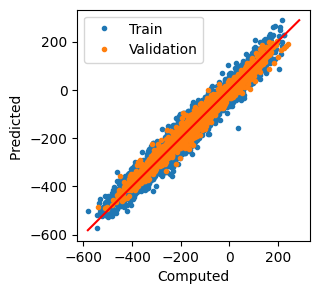

Epoch: 31, Train MAE: 17.9649, Val MAE: 16.9428
Epoch: 32, Train MAE: 17.8154, Val MAE: 16.9748
Epoch: 33, Train MAE: 17.5444, Val MAE: 17.0985
Epoch: 34, Train MAE: 17.3423, Val MAE: 16.9659
Epoch: 35, Train MAE: 17.2427, Val MAE: 16.5413
Epoch: 36, Train MAE: 17.0218, Val MAE: 16.3007
Epoch: 37, Train MAE: 16.8901, Val MAE: 16.4961
Epoch: 38, Train MAE: 16.6384, Val MAE: 16.2467
Epoch: 39, Train MAE: 16.3577, Val MAE: 15.9932
Epoch: 40, Train MAE: 16.3715, Val MAE: 15.9164


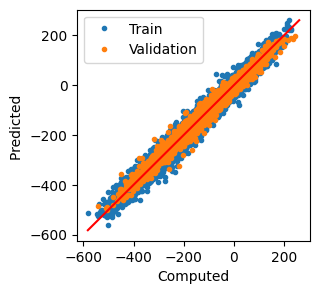

Epoch: 41, Train MAE: 16.1249, Val MAE: 15.6324
Epoch: 42, Train MAE: 16.0008, Val MAE: 15.6483
Epoch: 43, Train MAE: 15.8174, Val MAE: 15.5942
Epoch: 44, Train MAE: 15.7131, Val MAE: 15.6830
Epoch: 45, Train MAE: 15.7779, Val MAE: 15.5236
Epoch: 46, Train MAE: 15.5250, Val MAE: 15.6083
Epoch: 47, Train MAE: 15.4383, Val MAE: 15.5272
Epoch: 48, Train MAE: 15.3984, Val MAE: 15.5821
Epoch: 49, Train MAE: 15.0904, Val MAE: 15.4161
Epoch: 50, Train MAE: 15.0502, Val MAE: 15.2312


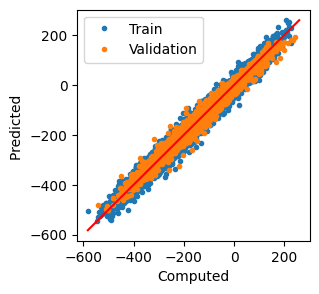

Epoch: 51, Train MAE: 14.9230, Val MAE: 15.4943
Epoch: 52, Train MAE: 14.8585, Val MAE: 15.4676
Epoch: 53, Train MAE: 14.7281, Val MAE: 15.1210
Epoch: 54, Train MAE: 14.6800, Val MAE: 14.9528
Epoch: 55, Train MAE: 14.6917, Val MAE: 15.1107
Epoch: 56, Train MAE: 14.4846, Val MAE: 15.4707
Epoch: 57, Train MAE: 14.6444, Val MAE: 15.0794
Epoch: 58, Train MAE: 14.3893, Val MAE: 15.2597
Epoch: 59, Train MAE: 14.2166, Val MAE: 15.0527
Epoch: 60, Train MAE: 14.1522, Val MAE: 14.9094


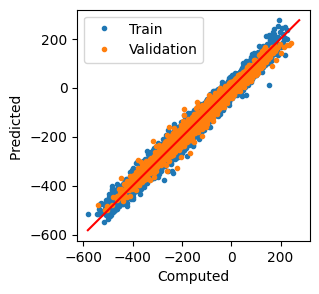

Epoch: 61, Train MAE: 14.1364, Val MAE: 15.4821
Epoch: 62, Train MAE: 14.7157, Val MAE: 15.0512
Epoch: 63, Train MAE: 14.0167, Val MAE: 14.5554
Epoch: 64, Train MAE: 13.8653, Val MAE: 15.0235
Epoch: 65, Train MAE: 13.8214, Val MAE: 14.8156
Epoch: 66, Train MAE: 13.8688, Val MAE: 14.8414
Epoch: 67, Train MAE: 13.6598, Val MAE: 14.9183
Epoch: 68, Train MAE: 13.7160, Val MAE: 14.5444
Epoch: 69, Train MAE: 13.5189, Val MAE: 14.5501
Epoch: 70, Train MAE: 13.4616, Val MAE: 14.6670


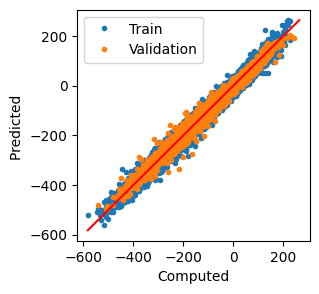

Epoch: 71, Train MAE: 13.5599, Val MAE: 14.6878
Epoch: 72, Train MAE: 13.3838, Val MAE: 14.4688
Epoch: 73, Train MAE: 13.4089, Val MAE: 14.5046
Epoch: 74, Train MAE: 13.3298, Val MAE: 14.5380
Epoch: 75, Train MAE: 13.2734, Val MAE: 14.5536
Epoch: 76, Train MAE: 13.1827, Val MAE: 14.3300
Epoch: 77, Train MAE: 13.0789, Val MAE: 14.4077
Epoch: 78, Train MAE: 13.1474, Val MAE: 14.3844
Epoch: 79, Train MAE: 13.0918, Val MAE: 14.3145
Epoch: 80, Train MAE: 13.0447, Val MAE: 14.7489


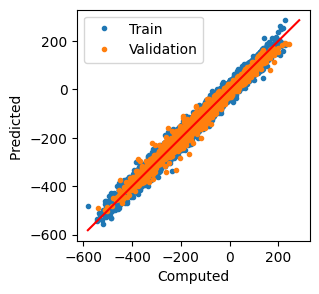

Epoch: 81, Train MAE: 12.9803, Val MAE: 14.4946
Epoch: 82, Train MAE: 12.9186, Val MAE: 14.5005
Epoch: 83, Train MAE: 12.8869, Val MAE: 14.0388
Epoch: 84, Train MAE: 12.8800, Val MAE: 14.1241
Epoch: 85, Train MAE: 12.7681, Val MAE: 14.4697
Epoch: 86, Train MAE: 12.8230, Val MAE: 14.1861
Epoch: 87, Train MAE: 12.6176, Val MAE: 14.0178
Epoch: 88, Train MAE: 12.6823, Val MAE: 14.1634
Epoch: 89, Train MAE: 12.6517, Val MAE: 14.5474
Epoch: 90, Train MAE: 12.5363, Val MAE: 14.3117


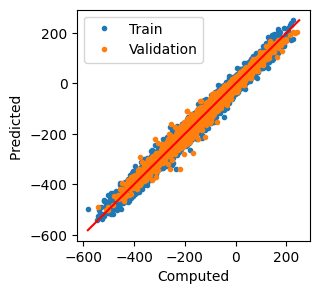

Epoch: 91, Train MAE: 12.5750, Val MAE: 14.0831
Epoch: 92, Train MAE: 12.6208, Val MAE: 14.1407
Epoch: 93, Train MAE: 12.5029, Val MAE: 13.9800
Epoch: 94, Train MAE: 12.3228, Val MAE: 14.2260
Epoch: 95, Train MAE: 12.4331, Val MAE: 13.8244
Epoch: 96, Train MAE: 12.3438, Val MAE: 13.9543
Epoch: 97, Train MAE: 12.3249, Val MAE: 14.1129
Epoch: 98, Train MAE: 12.2980, Val MAE: 14.0453
Epoch: 99, Train MAE: 12.2240, Val MAE: 14.0816
Epoch: 100, Train MAE: 12.2155, Val MAE: 14.0544


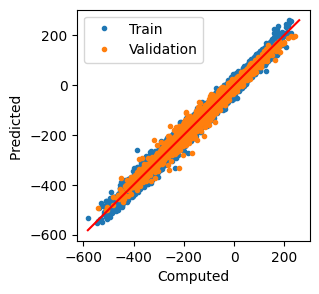

Epoch: 101, Train MAE: 12.1433, Val MAE: 14.0471
Epoch: 102, Train MAE: 12.0945, Val MAE: 13.9183
Epoch: 103, Train MAE: 12.1368, Val MAE: 13.9681
Epoch: 104, Train MAE: 12.0434, Val MAE: 13.7034
Epoch: 105, Train MAE: 12.0224, Val MAE: 13.9769
Epoch: 106, Train MAE: 12.0144, Val MAE: 13.8974
Epoch: 107, Train MAE: 12.0865, Val MAE: 14.0076
Epoch: 108, Train MAE: 11.9481, Val MAE: 13.6537
Epoch: 109, Train MAE: 11.8351, Val MAE: 13.8796
Epoch: 110, Train MAE: 11.9053, Val MAE: 13.7827


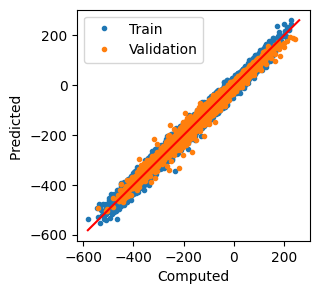

Epoch: 111, Train MAE: 11.8255, Val MAE: 13.8277
Epoch: 112, Train MAE: 11.8733, Val MAE: 14.0586
Epoch: 113, Train MAE: 11.8050, Val MAE: 13.8307
Epoch: 114, Train MAE: 11.7941, Val MAE: 13.7154
Epoch: 115, Train MAE: 11.7794, Val MAE: 13.7922
Epoch: 116, Train MAE: 11.7111, Val MAE: 13.5069
Epoch: 117, Train MAE: 11.7416, Val MAE: 13.9905
Epoch: 118, Train MAE: 11.7412, Val MAE: 14.0150
Epoch: 119, Train MAE: 11.8144, Val MAE: 14.1883
Epoch: 120, Train MAE: 11.6182, Val MAE: 13.9868


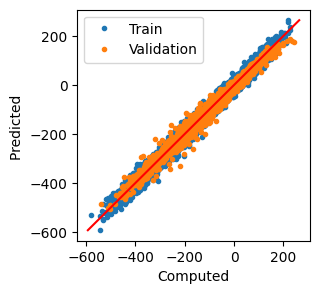

Epoch: 121, Train MAE: 11.6165, Val MAE: 13.9430
Epoch: 122, Train MAE: 11.5180, Val MAE: 13.7922
Epoch: 123, Train MAE: 11.4782, Val MAE: 13.5720
Epoch: 124, Train MAE: 11.5045, Val MAE: 13.7426
Epoch: 125, Train MAE: 11.4680, Val MAE: 13.5907
Epoch: 126, Train MAE: 11.3698, Val MAE: 13.5743
Epoch: 127, Train MAE: 11.5056, Val MAE: 14.4095
Epoch: 128, Train MAE: 11.5341, Val MAE: 14.0251
Epoch: 129, Train MAE: 11.4294, Val MAE: 13.6694
Epoch: 130, Train MAE: 11.3329, Val MAE: 13.8588


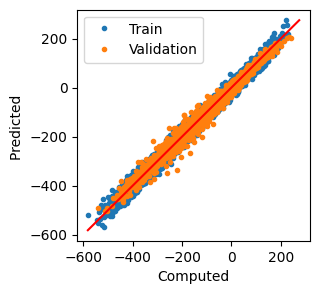

Epoch: 131, Train MAE: 11.3109, Val MAE: 13.6674
Epoch: 132, Train MAE: 11.3109, Val MAE: 13.6972
Epoch: 133, Train MAE: 11.3811, Val MAE: 13.4074
Epoch: 134, Train MAE: 11.2462, Val MAE: 13.8150
Epoch: 135, Train MAE: 11.2210, Val MAE: 13.3260
Epoch: 136, Train MAE: 11.1726, Val MAE: 13.3075
Epoch: 137, Train MAE: 11.1376, Val MAE: 13.9851
Epoch: 138, Train MAE: 11.0776, Val MAE: 13.4932
Epoch: 139, Train MAE: 11.2353, Val MAE: 13.8133
Epoch: 140, Train MAE: 11.2208, Val MAE: 13.8507


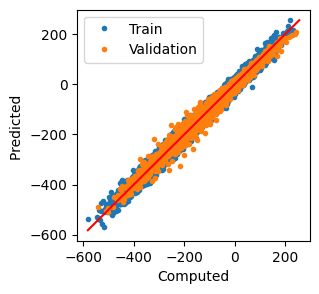

Epoch: 141, Train MAE: 11.1662, Val MAE: 13.6807
Epoch: 142, Train MAE: 11.0206, Val MAE: 13.5641
Epoch: 143, Train MAE: 11.0230, Val MAE: 13.9180
Epoch: 144, Train MAE: 11.0257, Val MAE: 13.5504
Epoch: 145, Train MAE: 11.0885, Val MAE: 13.9638
Epoch: 146, Train MAE: 10.9515, Val MAE: 13.7825
Epoch: 147, Train MAE: 11.0712, Val MAE: 13.7824
Epoch: 148, Train MAE: 11.0336, Val MAE: 13.5173
Epoch: 149, Train MAE: 10.9818, Val MAE: 13.5683
Epoch: 150, Train MAE: 10.9582, Val MAE: 13.6437


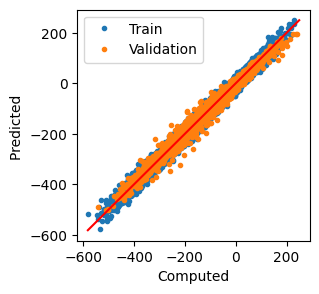

Epoch: 151, Train MAE: 10.9318, Val MAE: 13.7716
Epoch: 152, Train MAE: 10.8144, Val MAE: 13.5575
Epoch: 153, Train MAE: 10.8658, Val MAE: 13.3940
Epoch: 154, Train MAE: 10.8241, Val MAE: 13.5903
Epoch: 155, Train MAE: 10.7465, Val MAE: 13.5143
Epoch: 156, Train MAE: 10.8188, Val MAE: 13.4464
Epoch: 157, Train MAE: 10.7759, Val MAE: 13.5054
Epoch: 158, Train MAE: 10.8816, Val MAE: 13.2266
Epoch: 159, Train MAE: 10.7351, Val MAE: 13.4704
Epoch: 160, Train MAE: 10.7658, Val MAE: 13.3846


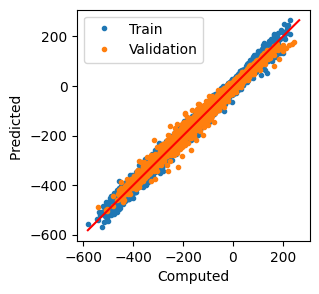

Epoch: 161, Train MAE: 10.7341, Val MAE: 13.8819
Epoch: 162, Train MAE: 10.8905, Val MAE: 14.1254
Epoch: 163, Train MAE: 10.8460, Val MAE: 13.3350
Epoch: 164, Train MAE: 10.7472, Val MAE: 13.4359
Epoch: 165, Train MAE: 10.7417, Val MAE: 13.4514
Epoch: 166, Train MAE: 10.6383, Val MAE: 13.4128
Epoch: 167, Train MAE: 10.5902, Val MAE: 13.8836
Epoch: 168, Train MAE: 10.6401, Val MAE: 13.4788
Epoch: 169, Train MAE: 10.6615, Val MAE: 13.3878
Epoch: 170, Train MAE: 10.5207, Val MAE: 13.3230


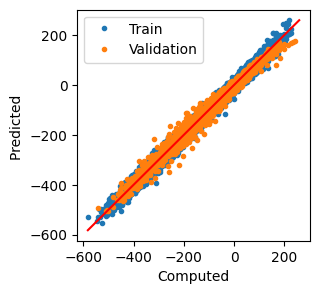

Epoch: 171, Train MAE: 10.5608, Val MAE: 13.6268
Epoch: 172, Train MAE: 10.5749, Val MAE: 13.6332
Epoch: 173, Train MAE: 10.4467, Val MAE: 13.1291
Epoch: 174, Train MAE: 10.6007, Val MAE: 13.3863
Epoch: 175, Train MAE: 10.5215, Val MAE: 13.3890
Epoch: 176, Train MAE: 10.6354, Val MAE: 13.3809
Epoch: 177, Train MAE: 10.4879, Val MAE: 13.1940
Epoch: 178, Train MAE: 10.5273, Val MAE: 13.3819
Epoch: 179, Train MAE: 10.4988, Val MAE: 13.6718
Epoch: 180, Train MAE: 10.4380, Val MAE: 13.1992


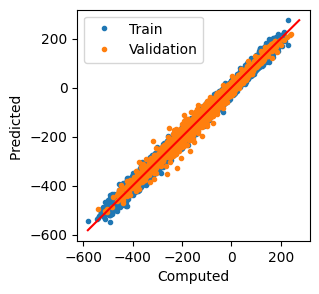

Epoch: 181, Train MAE: 10.4000, Val MAE: 13.2526
Epoch: 182, Train MAE: 10.3861, Val MAE: 13.3818
Epoch: 183, Train MAE: 10.4537, Val MAE: 13.0741
Epoch: 184, Train MAE: 10.4380, Val MAE: 13.5833
Epoch: 185, Train MAE: 10.3805, Val MAE: 13.4015
Epoch: 186, Train MAE: 10.4537, Val MAE: 13.4115
Epoch: 187, Train MAE: 10.3719, Val MAE: 13.2449
Epoch: 188, Train MAE: 10.4251, Val MAE: 13.1249
Epoch: 189, Train MAE: 10.3476, Val MAE: 13.4535
Epoch: 190, Train MAE: 10.2563, Val MAE: 12.9502


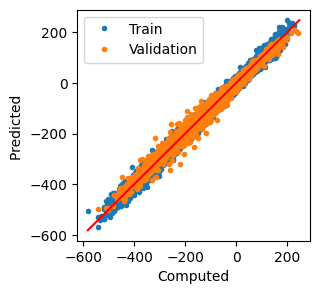

Epoch: 191, Train MAE: 10.3601, Val MAE: 13.3015
Epoch: 192, Train MAE: 10.2701, Val MAE: 13.1518
Epoch: 193, Train MAE: 10.3346, Val MAE: 13.2405
Epoch: 194, Train MAE: 10.2574, Val MAE: 13.5230
Epoch: 195, Train MAE: 10.1961, Val MAE: 13.2695
Epoch: 196, Train MAE: 10.1895, Val MAE: 13.1114
Epoch: 197, Train MAE: 10.3217, Val MAE: 13.1528
Epoch: 198, Train MAE: 10.3840, Val MAE: 13.2805
Epoch: 199, Train MAE: 10.2104, Val MAE: 13.3312
Epoch: 200, Train MAE: 10.2597, Val MAE: 13.1697


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in range(n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

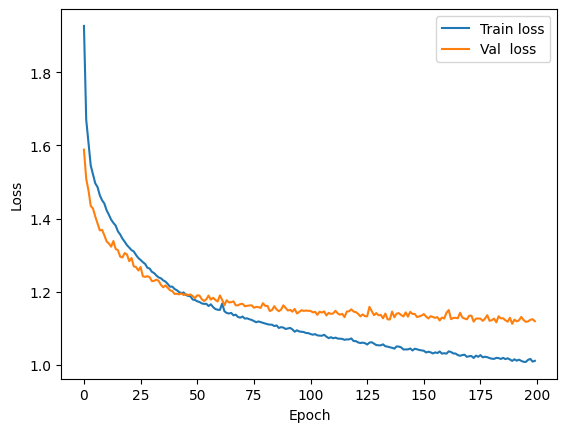

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [9]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(5, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

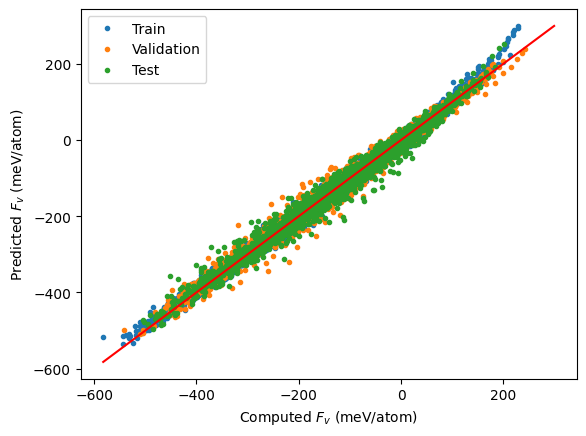

Train MAE: 7.6307, Val MAE: 13.1697, Test MAE: 13.8067


In [10]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [14]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]
for data in dataset:
    data.label = f'{data.label} {data.y[0]}'

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
